# Prepare SST dataset for comparison with CESM-LE

[Optimum Interpolation Sea Surface Temperature (OISST) v2.1](https://www.ncdc.noaa.gov/oisst/optimum-interpolation-sea-surface-temperature-oisst-v21)

The NOAA 1/4° daily Optimum Interpolation Sea Surface Temperature (or daily OISST) is an analysis constructed by combining observations from different platforms (satellites, ships, buoys and Argo floats) on a regular global grid. A spatially complete SST map is produced by interpolating to fill in gaps. The methodology includes bias adjustment of satellite and ship observations (referenced to buoys) to compensate for platform differences and sensor biases. This proved critical during the Mt. Pinatubo eruption in 1991, when the widespread presence of volcanic aerosols resulted in infrared satellite temperatures that were much cooler than actual ocean temperatures (Reynolds 1993). Starting from April 1, 2020, NCEI released a new version, OISST v2.1, to replace OISST v2. OISST v2 had been stopped on April 26, 2020 due to unavailable input data to it.

Currently OISST v2.1 data are available from Sept 1, 1981 onward and updated nominally daily. The new version has significant quality improvement for data starting from January 1, 2016 onward - see below for more details. For the data from September 1981 to December 2015, data for SST and SST anomaly are the same as v2 but format was updated from netCDF3 to netCDF4 with updated metadata in v2.1. 


This notebook does the following operations:

1. Download daily data via HTTP protocol from [here](https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr).

1. Compute monthly means from daily data.

1. Regrid monthly data from 1/4° native grid to the POP `gx1v6` grid. This has a few steps:
    - Generate SCRIP grid files for source and destination grids;
    - Use ESMF tool box to generate remapping weights;
    - Apply remapping weights.
    
1. Assemble remapped monthly data into a single file subsetted for the Southern Ocean domain.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import subprocess
import urllib
import calendar
from datetime import datetime
import tqdm

import numpy as np

import dask
import xarray as xr

import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [3]:
clobber = False
year_start = 1982
year_end = 2019
dst_grid = 'POP_gx1v6'

FILE_OUT_ANN = f'{util.project_tmpdir}/oisst-avhrr-v02r01.{year_start}-{year_end}_ANN.{dst_grid}.zarr'
FILE_OUT_DJF = f'{util.project_tmpdir}/oisst-avhrr-v02r01.{year_start}-{year_end}_DJF.{dst_grid}.zarr'
FILE_OUT_DJF

'/glade/p/cgd/oce/projects/krill-cesm-le/data/oisst-avhrr-v02r01.1982-2019_DJF.POP_gx1v6.zarr'

## Setup regridding machinery

Make SCRIP grid file for source grid.

In [4]:
gridfile_directory = f'{util.project_tmpdir}/regrid'
os.makedirs(gridfile_directory, exist_ok=True)

In [5]:
src_grid = 'latlon_0_25x0_25_lon0'
src_grid_file = f'{gridfile_directory}/{src_grid}.nc'

if not os.path.exists(src_grid_file) or clobber:
    dso = util.latlon_to_scrip(
        nx=1440, 
        ny=720, 
        lon0=0., 
        file_out=src_grid_file,
    )

Make SCRIP grid file for ocean model grid.

In [6]:
dst_grid_file= f'{gridfile_directory}/{dst_grid}.nc'

if not os.path.exists(dst_grid_file) or clobber:
    dso = pop_tools.get_grid('POP_gx1v6', scrip=True)
    del dso.attrs['region_mask_regions']
    print(f'writing {dst_grid_file}')
    dso.to_netcdf(dst_grid_file)

Call `ESMF_RegridWeightGen` to generate weight file.

In [7]:
%%time
method = 'conserve'
weight_file = f'{gridfile_directory}/{src_grid}_to_{dst_grid}_{method}.nc'

if not os.path.exists(weight_file) or clobber:
    cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
    out = subprocess.run(cmd, capture_output=True, check=True)
    print(out.stdout.decode('UTF-8'))

CPU times: user 0 ns, sys: 388 µs, total: 388 µs
Wall time: 652 µs


Set up remapping operator

In [8]:
regrid_op = util.regridder(src_grid_file, dst_grid_file, weight_file)
regrid_op

source grid dims: (720, 1440)
destination grid dims: (384, 320)


regridder latlon_0_25x0_25_lon0.nc --> POP_gx1v6.nc

## Download and process files

Set up some directories and xarray option for reading files.

In [9]:
dirloc = f'{util.project_tmpdir}/roisst'
dirtmp = f'/glade/scratch/{os.environ["USER"]}/roisst_daily'
os.makedirs(dirloc, exist_ok=True)
os.makedirs(dirtmp, exist_ok=True)

Define a function for computing monthly means from daily files.

In [10]:
@dask.delayed
def daily_to_mon(daily_files, mon_file):
    """compute monthly means from daily data"""
    ds = xr.open_mfdataset(daily_files, 
                           combine='by_coords',
                           decode_times=False,
                           decode_coords=False,
                          )
    assert ds.time.units == "days since 1978-01-01 12:00:00", (
        f'unexpected units: {ds.time.units}'
    )
    computed_dset = (ds
                     .mean(dim='time', keep_attrs=True)
                     .expand_dims(time=[ds.time.mean('time').values])
                    )
    
    # amend history
    history = ''
    if 'history' in computed_dset.attrs:
        history = computed_dset.attrs['history']
    computed_dset.attrs['history'] = 'average computed over: '+','.join(
        [os.path.basename(f) for f in daily_files]
    )
    
    # determine vars to regrid
    variables = computed_dset.variables    
    variables_to_regrid = [v for v in variables 
                           if not {'lat', 'lon'} - set(computed_dset[v].dims)
                          ]
    other_vars = [v for v in variables 
              if not {'lat', 'lon', 'zlev'}.intersection(set(computed_dset[v].dims))
             ]
    
    computed_dset_dst = computed_dset[other_vars]
    
    # regrid the data
    for v in variables_to_regrid:
        computed_dset_dst[v] = regrid_op.regrid_dataarray(
            computed_dset[v].compute(),
            renormalize=True, 
            apply_mask=True,
        ).squeeze('zlev')
    
    computed_dset_dst = computed_dset_dst.rename(
        {'lat': 'nlat', 'lon': 'nlon'}
    ).drop('zlev')
    
    # copy back encoding and attrs
    for v in computed_dset_dst.variables:
        encoding = ds[v].encoding
        attrs = ds[v].attrs
        if '_FillValue' not in encoding:
            encoding['_FillValue'] = None
        computed_dset_dst[v].encoding = encoding
        computed_dset_dst[v].attrs = attrs

    # set the time bounds
    computed_dset_dst['time_bnds'] = xr.DataArray(
        [[ds.time.values[0]-0.5, ds.time.values[-1]+0.5]], 
        dims=('time', 'd2'),
        coords=dict(time=computed_dset_dst.time),
        attrs=dict(long_name='time coverage',)
    )
    computed_dset_dst.time_bnds.encoding['_FillValue'] = None
    computed_dset_dst.time.attrs['long_name'] = 'time'
    computed_dset_dst.time.attrs['bounds'] = 'time_bnds'
    
    # write data to file
    computed_dset_dst.to_netcdf(mon_file, unlimited_dims=['time']) 
    

In [11]:
url = 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr'

@dask.delayed
def get_daily_files(year, month, day):
    """download remote files if needed"""
    file_name = f'oisst-avhrr-v02r01.{year:04d}{month:02d}{day:02d}.nc'            
    f_local = f'{dirtmp}/{file_name}'                
    if not os.path.exists(f_local) or clobber:
        dirsub = f'{year:04d}{month:02d}'
        f_remote = f'{url}/{dirsub}/{file_name}'
        urllib.request.urlretrieve(f_remote, f_local)   

    return f_local

def eomday(year, month):
    _, lastday = calendar.monthrange(year, month)     
    return lastday

In [12]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

try:
    cluster
    client
except:
    cluster = NCARCluster()
    cluster.scale(12)
    client = Client(cluster) # Connect this local process to remote workers
client

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.205.22:38108 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/32829/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [13]:
# loop over years/months/days
# generate a file name and URL
# save a list of files to transfer
delayed_objs = []
sst_files = []

for year in tqdm.tqdm(range(year_start, year_end+1)):

    for month in range(1, 13):
        
        # name the monthly file, generate if necessary
        mon_file = f'{dirloc}/oisst-avhrr-v02r01.{year:04d}{month:02d}_{dst_grid}.nc'
        sst_files.append(mon_file)
        if os.path.exists(mon_file) and not clobber:
            continue

        # loop over daily files and transfer if necessary
        daily_files = dask.compute(*[
            get_daily_files(year, month, day) for day in range(1, eomday(year, month)+1)
        ])

        # compute monthly mean and write monthly file
        delayed_objs.append(daily_to_mon(daily_files, mon_file))

if delayed_objs:
    res = dask.compute(*delayed_objs)

100%|██████████| 38/38 [00:00<00:00, 174.78it/s]


In [14]:
sst_files

['/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198201_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198202_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198203_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198204_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198205_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198206_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198207_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198208_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198209_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.198210_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roi

In [15]:
%%time
ds = xr.open_mfdataset(sst_files, combine='by_coords', decode_times=False)
ds = ds.set_coords(ds.time.bounds)
time_bnds = ds[ds.time.bounds]
ds = xr.decode_cf(ds.drop(ds.time.bounds), decode_times=True, use_cftime=True)
ds['time_bnds'] = time_bnds.assign_coords(time=ds.time)

pop_grid = pop_tools.get_grid('POP_gx1v6')[['TLAT', 'TLONG', 'KMT', 'TAREA']]
ds = xr.merge((ds, pop_grid))
ds

CPU times: user 6.58 s, sys: 372 ms, total: 6.95 s
Wall time: 16.3 s


,Array,Chunk
Bytes,224.13 MB,491.52 kB
Shape,"(456, 384, 320)","(1, 384, 320)"
Count,1368 Tasks,456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,224.13 MB,491.52 kB
Shape,"(456, 384, 320)","(1, 384, 320)"
Count,1368 Tasks,456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [16]:
ds_djf = util.ann_mean(ds, season='DJF', time_centered=True)
util.write_ds_out(ds_djf, FILE_OUT_DJF)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/oisst-avhrr-v02r01.1982-2019_DJF.POP_gx1v6.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	time = 37 ;

variables:
	float64 anom(time, nlat, nlon) ;
		anom:long_name = Daily sea surface temperature anomalies ;
		anom:valid_min = -1200 ;
		anom:valid_max = 1200 ;
		anom:units = Celsius ;
	float64 err(time, nlat, nlon) ;
		err:long_name = Estimated error standard deviation of analysed_sst ;
		err:units = Celsius ;
		err:valid_min = 0 ;
		err:valid_max = 1000 ;
	float64 ice(time, nlat, nlon) ;
		ice:long_name = Sea ice concentration ;
		ice:units = % ;
		ice:valid_min = 0 ;
		ice:valid_max = 100 ;
	float64 sst(time, nlat, nlon) ;
		sst:long_name = Daily sea surface temperature ;
		sst:units = Celsius ;
		sst:valid_min = -300 ;
		sst:valid_max = 4500 ;
	float64 TLAT(time, nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TLONG(time, nlat, nlon) ;
		TLO

In [17]:
ds_ann = util.ann_mean(ds, time_centered=True)
util.write_ds_out(ds_ann, FILE_OUT_ANN)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/oisst-avhrr-v02r01.1982-2019_ANN.POP_gx1v6.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	time = 38 ;

variables:
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;
	float64 TLAT(nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TLONG(nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 anom(time, nlat, nlon) ;
		anom:long_name = Daily sea surface temperature anomalies ;
		anom:valid_min = -1200 ;
		anom:valid_max = 1200 ;
		anom:units = Celsius ;
	float64 err(time, nlat, nlon) ;
		err:long_name = Estimated error standard deviation of analysed_sst ;
		err:units = Celsius ;
		err:valid_min = 0 ;
		err:valid_max = 1000 ;
	

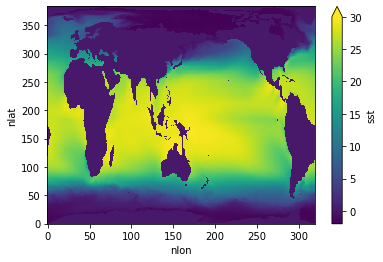

In [18]:
ds_djf.sst.mean('time').plot(vmin=-2, vmax=30)

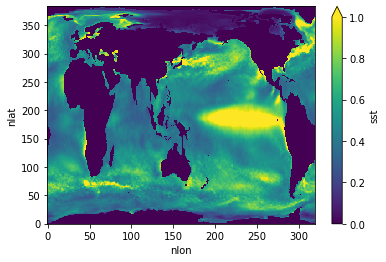

In [19]:
ds_djf.sst.std('time').plot(vmin=0, vmax=1)